# Model to predict sleep state based on Actigraphy data

## Requirements
Used and proved with Python 3.11.9

In [69]:
%pip install torch pandas polars seaborn matplotlib pyarrow
%pip install chronos-forecasting
%pip install autogluon

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


  Using cached transformers-4.53.1-py3-none-any.whl (10.8 MB)
  Using cached tokenizers-0.21.2-cp39-abi3-win_amd64.whl (2.5 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.27.1
    Uninstalling transformers-4.27.1:
      Successfully uninstalled transformers-4.27.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-timeseries 1.3.1 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.53.1 which is incompatible.
autogluon-multimodal 1.3.1 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.53.1 which is incompatible.
You should consider upgrading via the 'c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


  Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.1
    Uninstalling transformers-4.53.1:
      Successfully uninstalled transformers-4.53.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [70]:
%pip install --upgrade transformers==4.27.1
%pip install diffusers==0.14.0
%pip install cpm_kernels sentencepiece

  Using cached transformers-4.27.1-py3-none-any.whl (6.7 MB)
  Using cached tokenizers-0.13.3-cp310-cp310-win_amd64.whl (3.5 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.49.0
    Uninstalling transformers-4.49.0:
      Successfully uninstalled transformers-4.49.0
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chronos-forecasting 1.5.2 requires transformers<5,>=4.48, but you have transformers 4.27.1 which is incompatible.
autogluon-timeseries 1.3.1 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.27.1 which is incompatible.
autogluon-multimodal 1.3.1 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.27.1 which is incompatible.
You should consider upgrading via the 'c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.



Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [71]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

## A. Data acquisition
We optain the parquet with the data with:
- **ENMO**: Euclidean Norm Minus One, a measure of physical activity.
- **Anglez**: Angle of the wrist, which can indicate the position of the wrist.
- **Step**: step identifier.
- **Timestamp**: time of the measurement.

In [72]:
df = pl.read_parquet("data/train_series.parquet")

# Get the first series_id and filter data for that series only
first_series_id = df['series_id'].unique()[0]
df = df.filter(pl.col('series_id') == first_series_id)
print(f"Filtered data for series: {first_series_id}")
print(f"Data shape: {df.shape}")
print(df.head())

Filtered data for series: 8b8b9e29171c
Data shape: (623520, 5)
shape: (5, 5)
┌──────────────┬──────┬──────────────────────────┬─────────┬────────┐
│ series_id    ┆ step ┆ timestamp                ┆ anglez  ┆ enmo   │
│ ---          ┆ ---  ┆ ---                      ┆ ---     ┆ ---    │
│ str          ┆ u32  ┆ str                      ┆ f32     ┆ f32    │
╞══════════════╪══════╪══════════════════════════╪═════════╪════════╡
│ 8b8b9e29171c ┆ 0    ┆ 2018-04-25T11:15:00-0400 ┆ -3.1271 ┆ 0.0415 │
│ 8b8b9e29171c ┆ 1    ┆ 2018-04-25T11:15:05-0400 ┆ 1.6326  ┆ 0.0454 │
│ 8b8b9e29171c ┆ 2    ┆ 2018-04-25T11:15:10-0400 ┆ 1.424   ┆ 0.0568 │
│ 8b8b9e29171c ┆ 3    ┆ 2018-04-25T11:15:15-0400 ┆ -3.6716 ┆ 0.0572 │
│ 8b8b9e29171c ┆ 4    ┆ 2018-04-25T11:15:20-0400 ┆ -8.707  ┆ 0.032  │
└──────────────┴──────┴──────────────────────────┴─────────┴────────┘


### Graphs
We plot the data to visualize the activity and angle over time.

#### ENMO

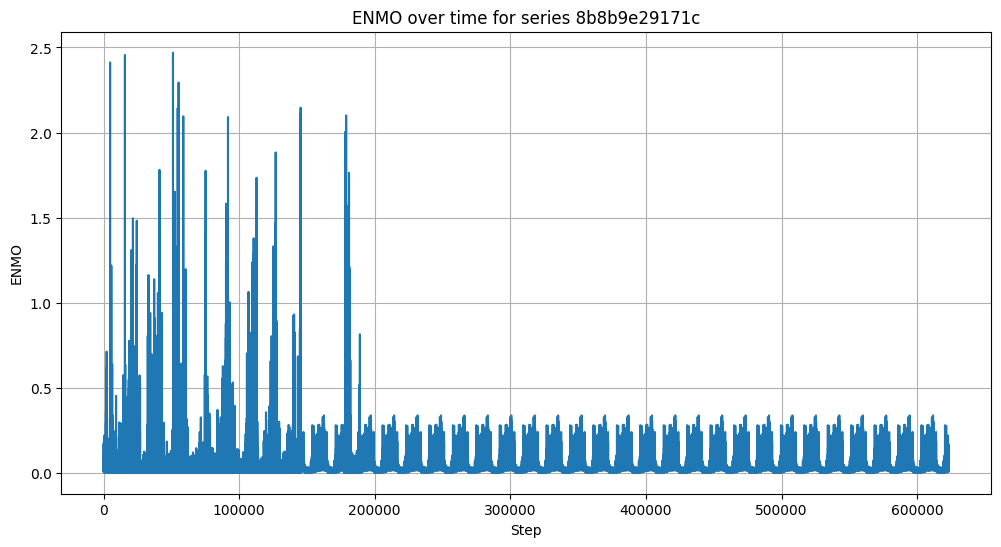

In [73]:
# Plot ENMO vs step for the first series
plt.figure(figsize=(12, 6))
plt.plot(df['step'], df['enmo'])
plt.title(f'ENMO over time for series {first_series_id}')
plt.xlabel('Step')
plt.ylabel('ENMO')
plt.grid(True)
plt.show()

#### Anglez

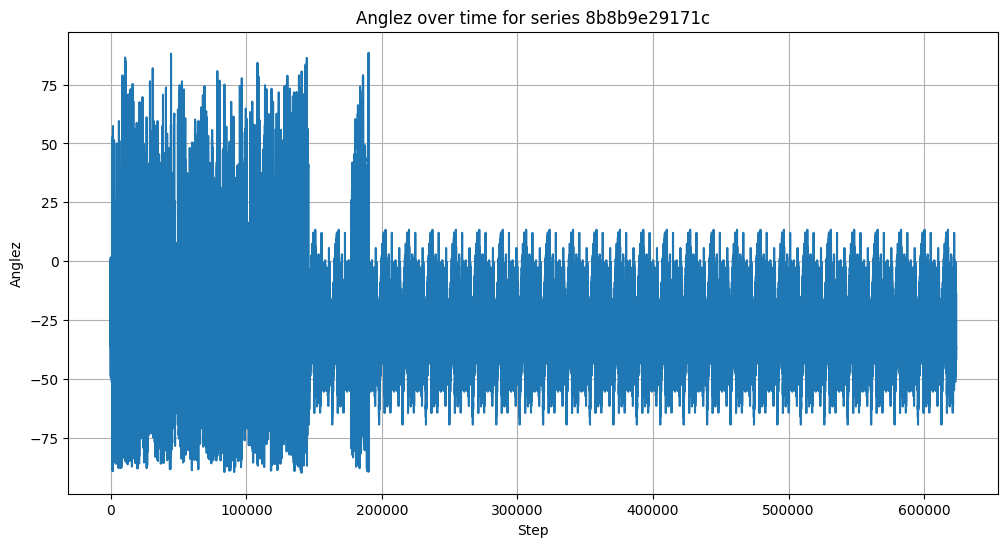

In [74]:
# Plot anglez vs step for the first series
plt.figure(figsize=(12, 6))
plt.plot(df['step'], df['anglez'])
plt.title(f'Anglez over time for series {first_series_id}')
plt.xlabel('Step')
plt.ylabel('Anglez')
plt.grid(True)
plt.show()

## B. Data processing
We obtain raw data and calibrate and filter it to prepare for modeling.
The processing includes:
- **Calibration**: Adjusting the ENMO and Anglez values to fix any biases.
- **Normalization**: Scaling the data to a standard range.
- **Filtering**: Removing noise from the data to improve model performance.
- **Gap replacement**: Filling in missing data points to ensure continuity.

### B.1 Calibration
Adjust the ENMO and Anglez values to fix any biases. 

In [75]:
enmo_calibrated = np.clip(df['enmo'].to_numpy(), 0, None)
anglez_calibrated = df['anglez'].to_numpy()

### B.2 Normalization
Scale the data to a standard range, typically between 0 and 1, to ensure that all features contribute equally to the model.

In [76]:
# Min-Max Normalization
enmo_norm = (enmo_calibrated - enmo_calibrated.min()) / (enmo_calibrated.max() - enmo_calibrated.min())
anglez_norm = 2 * (anglez_calibrated - anglez_calibrated.min()) / (anglez_calibrated.max() - anglez_calibrated.min()) - 1

### visualization


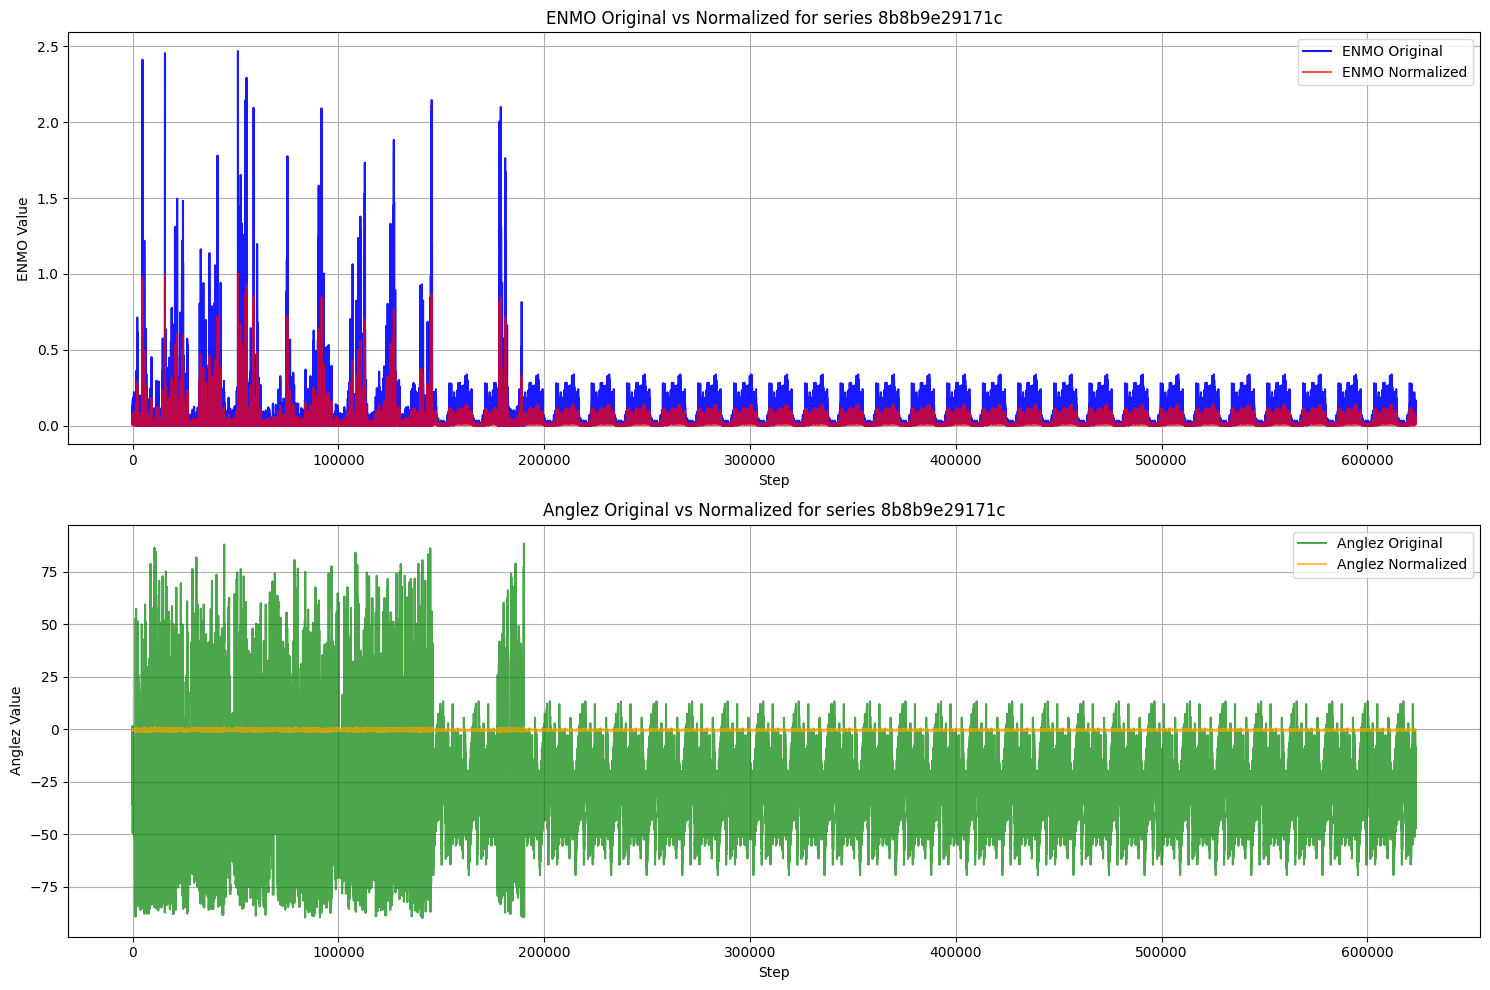

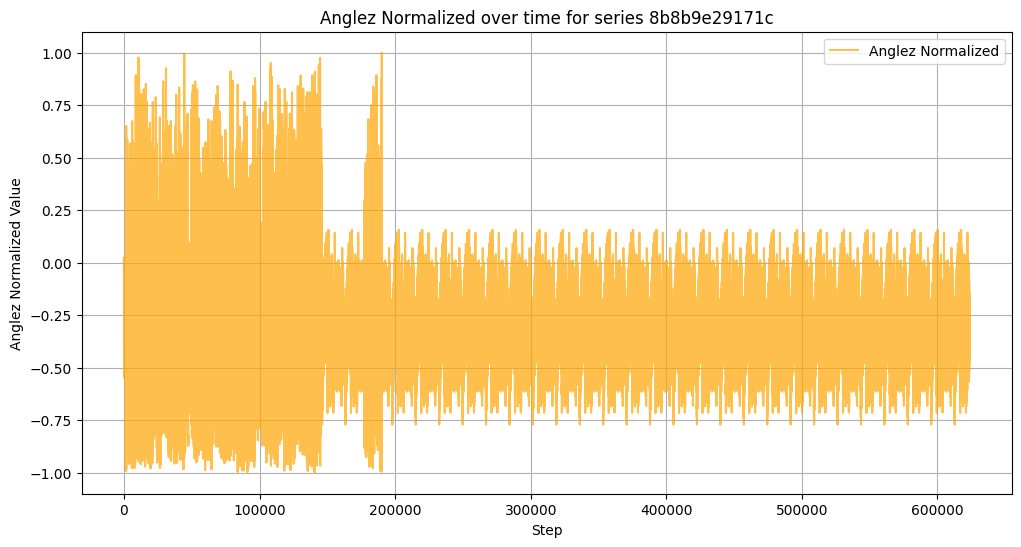

In [77]:
# Create subplots for ENMO comparison
plt.figure(figsize=(15, 10))

# ENMO comparison subplot
plt.subplot(2, 1, 1)
sns.lineplot(x=df['step'], y=df['enmo'], label='ENMO Original', color='blue', alpha=0.9)
sns.lineplot(x=df['step'], y=enmo_norm, label='ENMO Normalized', color='red', alpha=0.7)
plt.title(f'ENMO Original vs Normalized for series {first_series_id}')
plt.xlabel('Step')
plt.ylabel('ENMO Value')
plt.legend()
plt.grid(True)

# Anglez comparison subplot
plt.subplot(2, 1, 2)
sns.lineplot(x=df['step'], y=df['anglez'], label='Anglez Original', color='green', alpha=0.7)
sns.lineplot(x=df['step'], y=anglez_norm, label='Anglez Normalized', color='orange', alpha=0.7)
plt.title(f'Anglez Original vs Normalized for series {first_series_id}')
plt.xlabel('Step')
plt.ylabel('Anglez Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.lineplot(x=df['step'], y=anglez_norm, label='Anglez Normalized', color='orange', alpha=0.7)
plt.title(f'Anglez Normalized over time for series {first_series_id}')
plt.xlabel('Step')
plt.ylabel('Anglez Normalized Value')
plt.legend()
plt.grid(True)
plt.show()

### B.3 Filtering
Remove noise from the data to improve model performance. Using a moving average filter to smooth the data.

In [78]:
# Media móvil con ventana de 6 epochs (~30s si cada epoch es 5s)
window_size = 6
enmo_filtered = np.convolve(enmo_calibrated, np.ones(window_size)/window_size, mode='same')
anglez_filtered = np.convolve(anglez_calibrated, np.ones(window_size)/window_size, mode='same')

#### Gap reduction
The dataset have been already cleaned, so we don't need to fill gaps.

## C. Feature Extraction
Extract relevant features from the processed data that can be used for modeling. 

In [79]:
# Define epoch length: 12 steps = 60 seconds (since each step represents 5 seconds)
epoch_len = 12
# A list to store the filtered data
epoch_features = []

# Iterate through the data in epochs
for i in range(0, len(enmo_filtered), epoch_len):

    # Early break, ensuring no overpass the array's length
    if i + epoch_len > len(enmo_filtered):
        break
    
    # Get the current epoch data
    enmo_epoch = enmo_filtered[i:i + epoch_len]
    anglez_epoch = anglez_filtered[i:i + epoch_len]

    # C.1 Activity count
    activity_count = np.sum(enmo_epoch) *1000  # Typical scale factor

    # C.2 Anglez mean and std (Time Pattern)
    anglez_mean = np.mean(anglez_epoch)
    anglez_std = np.std(anglez_epoch)

    epoch_features.append({
        'epoch_start_step': df['step'][i],
        'activity_count': activity_count,
        'anglez_mean': anglez_mean,
        'anglez_std': anglez_std
    })

# Convert the list of epoch features to a DataFrame
epoch_df = pd.DataFrame(epoch_features)

print(f"Número de epochs creados: {epoch_df.shape[0]}")
print("Primeros 5 epochs con sus features:")
print(epoch_df.head())

# --- C.2 Feature Sorter ---
# Classify and organize the data for the next step (Classification)
print(f"\nFeature extraction completed.")
print(f"Features extracted: {list(epoch_df.columns)}")
print(f"Data shape ready for classification: {epoch_df.shape}")
print(f"Activity count range: [{epoch_df['activity_count'].min():.2f}, {epoch_df['activity_count'].max():.2f}]")
print(f"Anglez stability range: [{epoch_df['anglez_std'].min():.2f}, {epoch_df['anglez_std'].max():.2f}]")

Número de epochs creados: 51960
Primeros 5 epochs con sus features:
   epoch_start_step  activity_count  anglez_mean  anglez_std
0                 0      509.266667    -5.955663    3.354177
1                12      472.366669   -13.731978    2.808477
2                24      350.183332   -22.515332    2.924987
3                36      302.016665   -23.852611    5.306313
4                48      452.800001   -19.398242    3.006442

Feature extraction completed.
Features extracted: ['epoch_start_step', 'activity_count', 'anglez_mean', 'anglez_std']
Data shape ready for classification: (51960, 4)
Activity count range: [0.00, 11671.53]
Anglez stability range: [0.00, 62.77]


## D. Classification
Classify sleep/wake states using established actigraphy algorithms.


### D.1 Sleep State Detector

In [80]:
def sadeh_algorithm(activity_counts):
    """
    Sadeh Algorithm (1994) for sleep/wake classification
    Reference: Sadeh, A., Sharkey, K. M., & Carskadon, M. A. (1994). 
    Activity-based sleep-wake identification: an empirical test of methodological issues.
    """
    sleep_scores = []
    
    for i in range(len(activity_counts)):
        # Get current epoch and surrounding epochs for context
        current = activity_counts[i]
        
        # Get previous and next epochs (with boundary handling)
        prev_2 = activity_counts[max(0, i-2)] if i >= 2 else 0
        prev_1 = activity_counts[max(0, i-1)] if i >= 1 else 0
        next_1 = activity_counts[min(len(activity_counts)-1, i+1)] if i < len(activity_counts)-1 else 0
        next_2 = activity_counts[min(len(activity_counts)-1, i+2)] if i < len(activity_counts)-2 else 0
        
        # Sadeh formula: 7.601 - 0.065*ACT - 1.08*NATS - 0.056*SD - 0.073*LG
        # Simplified version using available data
        nat_log = np.log(current + 1)  # Natural log of activity (+1 to avoid log(0))
        
        # Calculate standard deviation of surrounding epochs
        surrounding = [prev_2, prev_1, current, next_1, next_2]
        std_dev = np.std(surrounding)
        
        # Sadeh score calculation (simplified)
        sadeh_score = 7.601 - 0.065*current - 1.08*nat_log - 0.056*std_dev
        
        # Sleep if score > 0, Wake if score <= 0
        sleep_scores.append(1 if sadeh_score > 0 else 0)
    
    return np.array(sleep_scores)

def cole_kripke_algorithm(activity_counts):
    """
    Cole-Kripke Algorithm (1992) for sleep/wake classification
    Reference: Cole, R. J., Kripke, D. F., Gruen, W., Mullaney, D. J., & Gillin, J. C. (1992).
    Automatic sleep/wake identification from wrist activity.
    """
    sleep_scores = []
    
    for i in range(len(activity_counts)):
        # Get current epoch and surrounding epochs
        current = activity_counts[i]
        
        # Get surrounding epochs with boundary handling
        prev_4 = activity_counts[max(0, i-4)] if i >= 4 else 0
        prev_3 = activity_counts[max(0, i-3)] if i >= 3 else 0
        prev_2 = activity_counts[max(0, i-2)] if i >= 2 else 0
        prev_1 = activity_counts[max(0, i-1)] if i >= 1 else 0
        next_1 = activity_counts[min(len(activity_counts)-1, i+1)] if i < len(activity_counts)-1 else 0
        next_2 = activity_counts[min(len(activity_counts)-1, i+2)] if i < len(activity_counts)-2 else 0
        
        # Cole-Kripke weighted formula
        cole_score = (0.0036*prev_4 + 0.0136*prev_3 + 0.0545*prev_2 + 
                     0.1731*prev_1 + 0.4910*current + 0.1731*next_1 + 0.0545*next_2)
        
        # Sleep if score < threshold (typically around 1.0 for scaled activity counts)
        # Adjust threshold based on your activity count scale
        threshold = 1.0
        sleep_scores.append(1 if cole_score < threshold else 0)
    
    return np.array(sleep_scores)

def opal_algorithm(activity_counts, anglez_std):
    """
    OPAL Algorithm for sleep/wake classification using activity and posture.
    This version uses a logistic regression-inspired approach to combine features.
    
    Reference: Inspired by the principles of the OPAL sensor system, which
    combines multiple sensor modalities for robust activity classification.
    """
    # Ensure inputs are numpy arrays for vectorized operations
    activity_counts = np.array(activity_counts)
    anglez_std = np.array(anglez_std)

    # 1. Log-transform activity to reduce skewness from high-activity bursts
    # Adding a small constant to handle zero activity counts
    log_activity = np.log(activity_counts + 1)

    # 2. Normalize features to a comparable scale (e.g., 0 to 1)
    # This prevents features with larger ranges from dominating the model.
    # We use robust scaling with percentiles to mitigate the effect of outliers.
    activity_p5 = np.percentile(log_activity, 5)
    activity_p95 = np.percentile(log_activity, 95)
    
    # Clip to prevent division by zero or extreme values if p95 and p5 are close
    if activity_p95 - activity_p5 > 1e-6:
        norm_activity = (log_activity - activity_p5) / (activity_p95 - activity_p5)
        norm_activity = np.clip(norm_activity, 0, 1)
    else:
        norm_activity = np.zeros_like(log_activity)

    stability_p5 = np.percentile(anglez_std, 5)
    stability_p95 = np.percentile(anglez_std, 95)
    
    if stability_p95 - stability_p5 > 1e-6:
        # Higher std means lower stability, so we invert the score
        norm_stability = 1 - ((anglez_std - stability_p5) / (stability_p95 - stability_p5))
        norm_stability = np.clip(norm_stability, 0, 1)
    else:
        norm_stability = np.ones_like(anglez_std)

    # 3. Combine features using a weighted logistic function
    # These weights and intercept are heuristic but based on common findings:
    # - Low activity is a strong indicator of sleep (higher negative weight).
    # - High stability is a good indicator of sleep (positive weight for inverted stability).
    # The intercept biases the model towards wakefulness, requiring strong evidence for sleep.
    w_activity = -2.5  # Negative weight: higher activity decreases sleep probability
    w_stability = 1.5   # Positive weight: higher stability increases sleep probability
    intercept = -1.0    # Bias term

    # Calculate the linear combination of features
    z = intercept + w_activity * norm_activity + w_stability * norm_stability
    
    # 4. Apply the sigmoid function to get a sleep probability score [0, 1]
    sleep_prob = 1 / (1 + np.exp(-z))
    
    # 5. Classify as sleep if the probability is > 0.5
    sleep_scores = (sleep_prob > 0.5).astype(int)
    
    return sleep_scores

In [81]:
# Apply all three algorithms to your epoch data
print("Applying sleep classification algorithms...")

# Extract activity counts and anglez std for algorithms
activity_counts = epoch_df['activity_count'].values
anglez_std_values = epoch_df['anglez_std'].values

# Apply algorithms
sadeh_results = sadeh_algorithm(activity_counts)
cole_kripke_results = cole_kripke_algorithm(activity_counts)
opal_results = opal_algorithm(activity_counts, anglez_std_values)

Applying sleep classification algorithms...


In [82]:
# Add results to DataFrame
epoch_df['sadeh_sleep'] = sadeh_results
epoch_df['cole_kripke_sleep'] = cole_kripke_results  
epoch_df['opal_sleep'] = opal_results

print(f"Classification completed for {len(epoch_df)} epochs:")
print(f"Sadeh - Sleep epochs: {np.sum(sadeh_results)}/{len(sadeh_results)} ({np.mean(sadeh_results)*100:.1f}%)")
print(f"Cole-Kripke - Sleep epochs: {np.sum(cole_kripke_results)}/{len(cole_kripke_results)} ({np.mean(cole_kripke_results)*100:.1f}%)")
print(f"Opal - Sleep epochs: {np.sum(opal_results)}/{len(opal_results)} ({np.mean(opal_results)*100:.1f}%)")

print("\nFirst 10 epochs with classifications:")
print(epoch_df[['epoch_start_step', 'activity_count', 'anglez_std', 'sadeh_sleep', 'cole_kripke_sleep', 'opal_sleep']].head(200))

Classification completed for 51960 epochs:
Sadeh - Sleep epochs: 10023/51960 (19.3%)
Cole-Kripke - Sleep epochs: 2088/51960 (4.0%)
Opal - Sleep epochs: 4238/51960 (8.2%)

First 10 epochs with classifications:
     epoch_start_step  activity_count  anglez_std  sadeh_sleep  \
0                   0      509.266667    3.354177            0   
1                  12      472.366669    2.808477            0   
2                  24      350.183332    2.924987            0   
3                  36      302.016665    5.306313            0   
4                  48      452.800001    3.006442            0   
..                ...             ...         ...          ...   
195              2340     1639.533347   11.001396            0   
196              2352     1898.633313    3.854787            0   
197              2364      998.716671   15.901624            0   
198              2376      490.483335    3.181470            0   
199              2388      188.550003    6.563621            0   

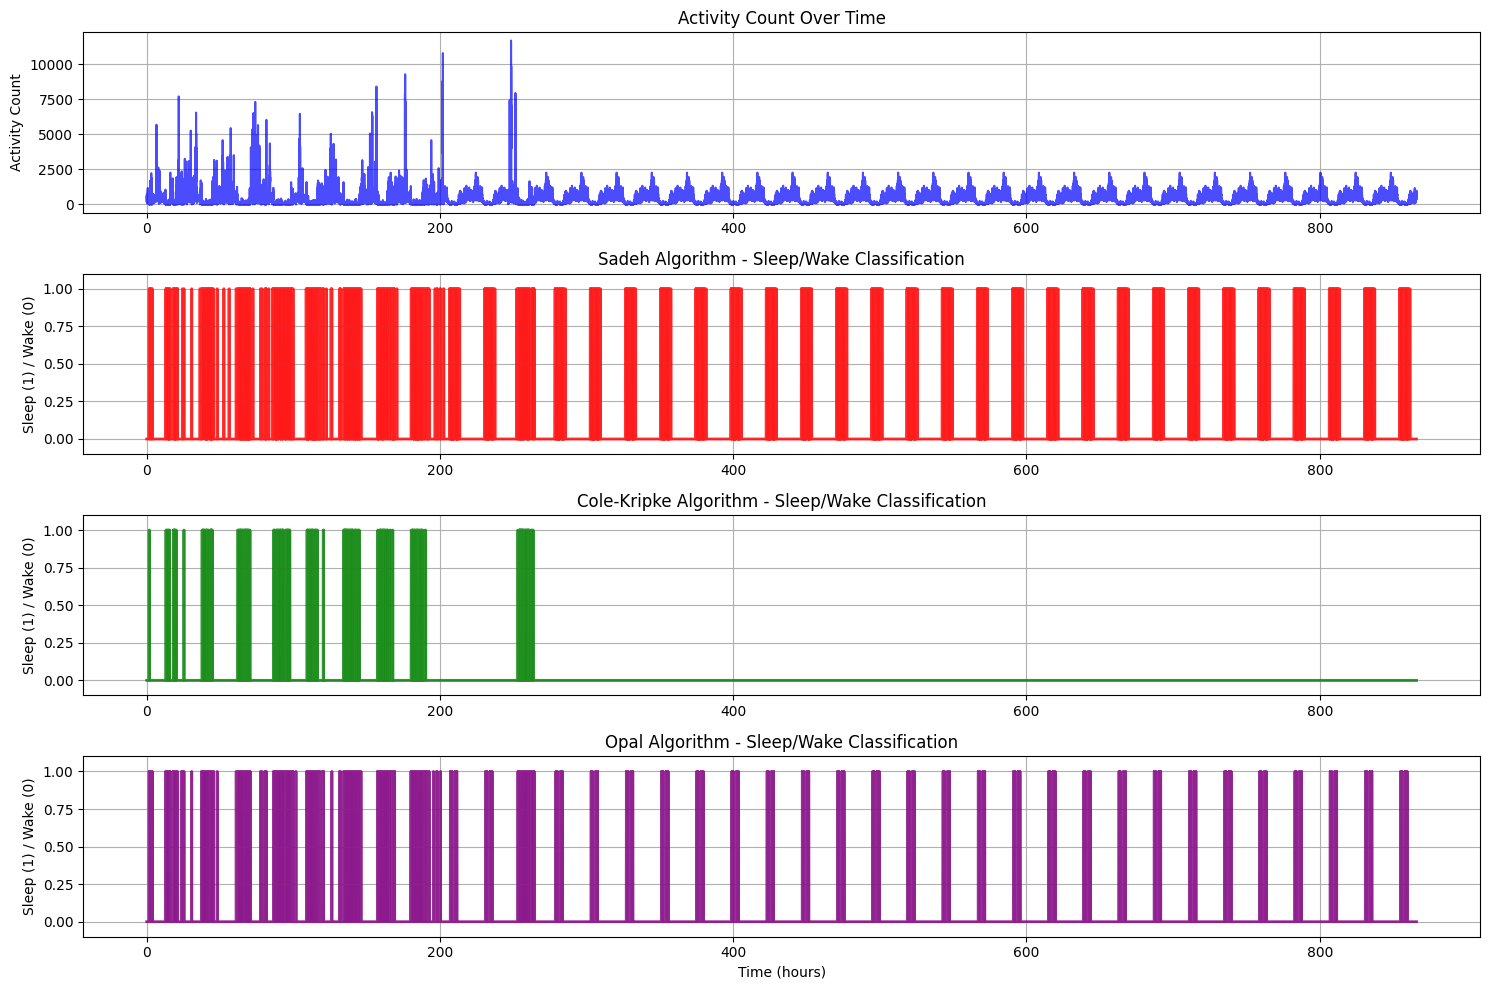

In [83]:
# Visualize the sleep/wake classifications
plt.figure(figsize=(15, 10))

# Create time axis (convert epoch steps to hours for better readability)
# 12 - 24 - 36 - 48
# 1 - 2 - 3 - 4

time_hours = epoch_df['epoch_start_step'].to_numpy()/(12*60) # minutes


# Plot 1: Activity Count over time
plt.subplot(4, 1, 1)
plt.plot(time_hours, epoch_df['activity_count'], alpha=0.7, color='blue')
plt.title('Activity Count Over Time')
plt.ylabel('Activity Count')
plt.grid(True)

# Plot 2: Sadeh Classification
plt.subplot(4, 1, 2)
plt.plot(time_hours, epoch_df['sadeh_sleep'], alpha=0.8, color='red', linewidth=2)
plt.fill_between(time_hours, 0, epoch_df['sadeh_sleep'], alpha=0.3, color='red')
plt.title('Sadeh Algorithm - Sleep/Wake Classification')
plt.ylabel('Sleep (1) / Wake (0)')
plt.ylim(-0.1, 1.1)
plt.grid(True)

# Plot 3: Cole-Kripke Classification  
plt.subplot(4, 1, 3)
plt.plot(time_hours, epoch_df['cole_kripke_sleep'], alpha=0.8, color='green', linewidth=2)
plt.fill_between(time_hours, 0, epoch_df['cole_kripke_sleep'], alpha=0.3, color='green')
plt.title('Cole-Kripke Algorithm - Sleep/Wake Classification')
plt.ylabel('Sleep (1) / Wake (0)')
plt.ylim(-0.1, 1.1)
plt.grid(True)

# Plot 4: Opal Classification
plt.subplot(4, 1, 4)
plt.plot(time_hours, epoch_df['opal_sleep'], alpha=0.8, color='purple', linewidth=2)
plt.fill_between(time_hours, 0, epoch_df['opal_sleep'], alpha=0.3, color='purple')
plt.title('Opal Algorithm - Sleep/Wake Classification')
plt.ylabel('Sleep (1) / Wake (0)')
plt.xlabel('Time (hours)')
plt.ylim(-0.1, 1.1)
plt.grid(True)

plt.tight_layout()
plt.show()

### D.2 Sleep Data Sequencer

Now we have to iterate over the data to find the longest sleep period, at least 30 minutes, and extract it.

In [84]:
epoch_df

,epoch_start_step,activity_count,anglez_mean,anglez_std,sadeh_sleep,cole_kripke_sleep,opal_sleep
0,0,509.266667,-5.955663,3.354177,0,0,0
1,12,472.366669,-13.731978,2.808477,0,0,0
2,24,350.183332,-22.515332,2.924987,0,0,0
3,36,302.016665,-23.852611,5.306313,0,0,0
4,48,452.800001,-19.398242,3.006442,0,0,0
...,...,...,...,...,...,...,...
51955,623460,499.150002,-26.908173,2.773484,0,0,0
51956,623472,352.416668,-24.750586,2.172303,0,0,0
51957,623484,441.800004,-26.670540,2.562081,0,0,0
51958,623496,757.083333,-18.624897,2.267479,0,0,0


## E. Sleep State Prediction
Use the extracted features to predict sleep states using a LLM (Amazon's Chronos model).


### E.1 Importing Model chronos-forecasting

In [ ]:
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-tiny",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#### E.2 Algorithms Data Adquisition

The data from every algorithm is divided by 180 in order to get 15 minutes intervals to, which 10 minutes are used to train the model and 5 minutes
to predice and comparate to analyze the model precision 

In [ ]:

sadeh_data = epoch_df['sadeh_sleep']
cole_kripke_sleep_data = epoch_df['cole_kripke_sleep']
opal_sleep_data = epoch_df['opal_sleep']

In [87]:
def predict_sleep_states(pipeline, data, container, name):

    chunks = np.array_split(data, len(data) // 180)
    lows = torch.empty((0), dtype=torch.bfloat16)
    medians = torch.empty((0), dtype=torch.bfloat16)
    highs = torch.empty((0), dtype=torch.bfloat16)
    real_data = np.array([])

    for data in chunks:
        data_predict = data[:120]
        data_test = data[120:]
        real_data = np.concatenate((real_data, data_test.to_numpy()), axis=0)
        quantiles, mean = pipeline.predict_quantiles(
            context=torch.tensor(data_predict.to_numpy()),
            prediction_length=60,
            quantile_levels=[0.1, 0.5, 0.9],
        )
        low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]
        lows = torch.cat((lows, low), dim=0)
        medians = torch.cat((medians, median), dim=0)
        highs = torch.cat((highs, high), dim=0)
        container[name] = lows, medians, highs, real_data
        


The model runs for every algorithm data in multithreading process to maximize resources

In [88]:
import threading

results = {'Sadeh': None, 'Cole_kripke': None, 'Opal': None}
saddeh_thread = threading.Thread(target=predict_sleep_states, args=(pipeline, sadeh_data, results, 'Sadeh'))
cole_kripke_thread = threading.Thread(target=predict_sleep_states, args=(pipeline, cole_kripke_sleep_data, results, 'Cole_kripke'))
opal_thread = threading.Thread(target=predict_sleep_states, args=(pipeline, opal_sleep_data, results, 'Opal'))

saddeh_thread.start()
cole_kripke_thread.start()
opal_thread.start()
saddeh_thread.join()
cole_kripke_thread.join()
opal_thread.join()



c:\Users\USUARIO\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


### E.3 Results

The following graphics shows the similarity between predicted data and real data, within threshold from the model and the middle the most accurate prediction, the prediction median

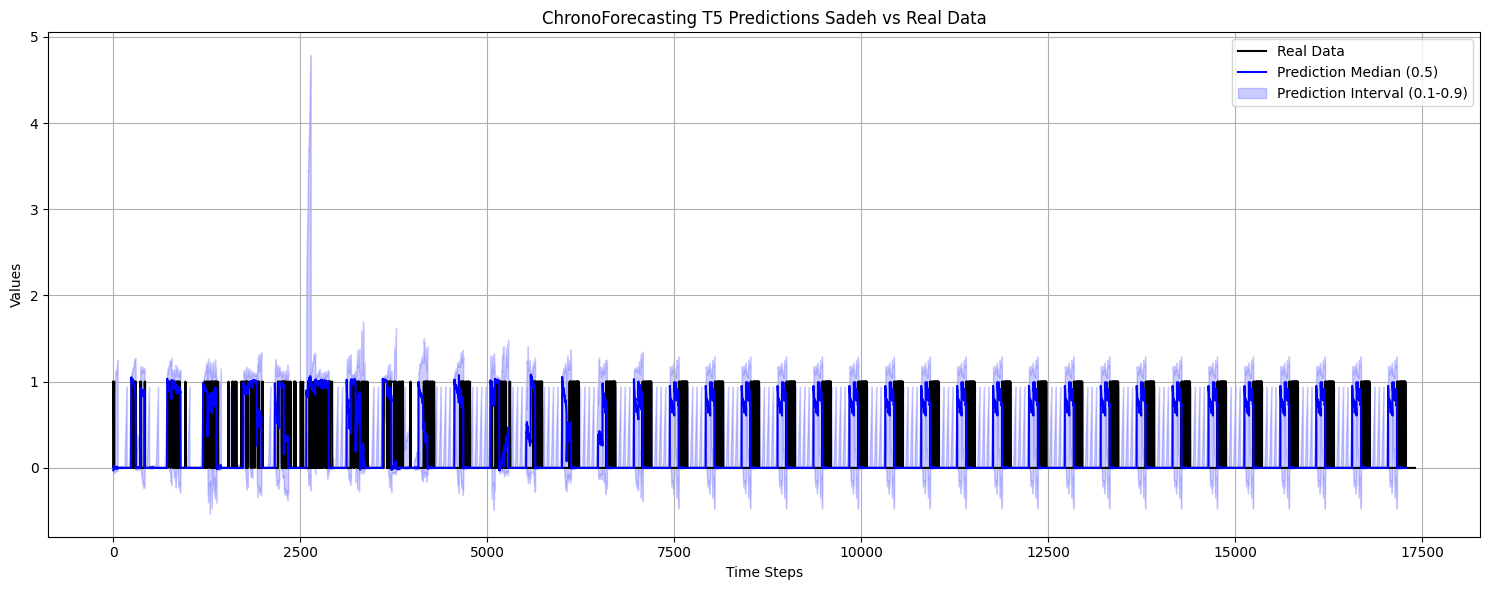

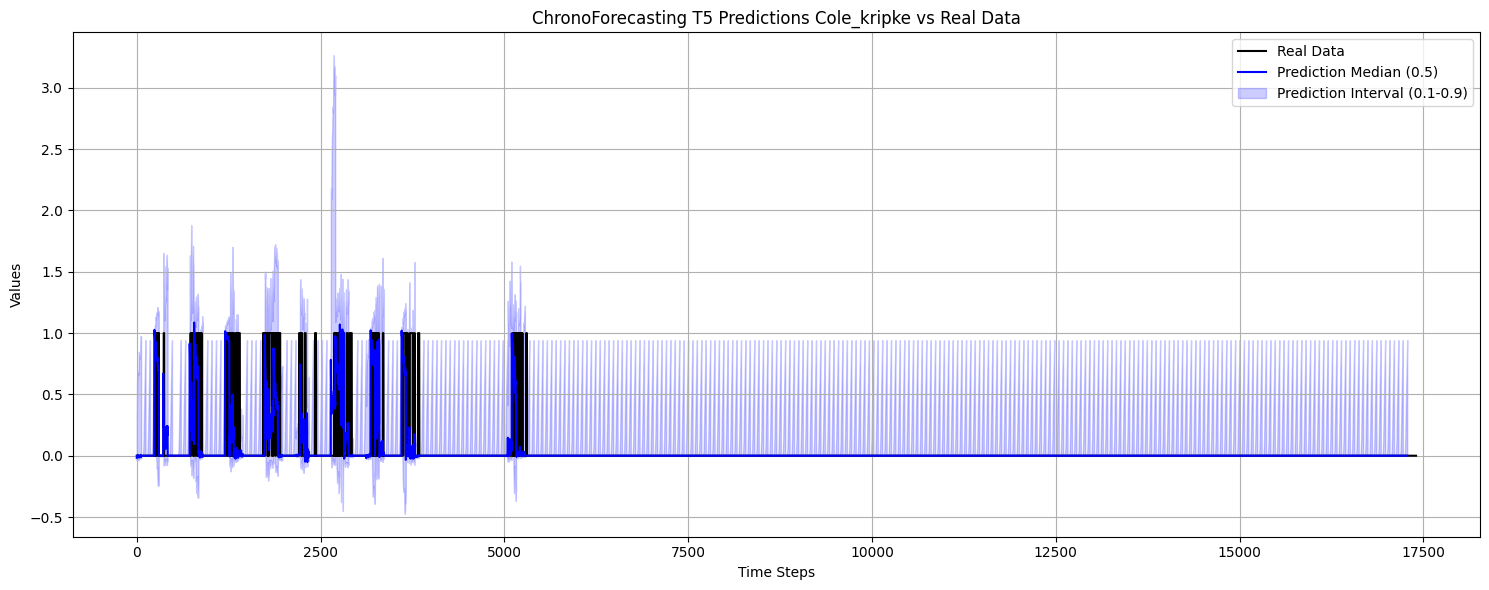

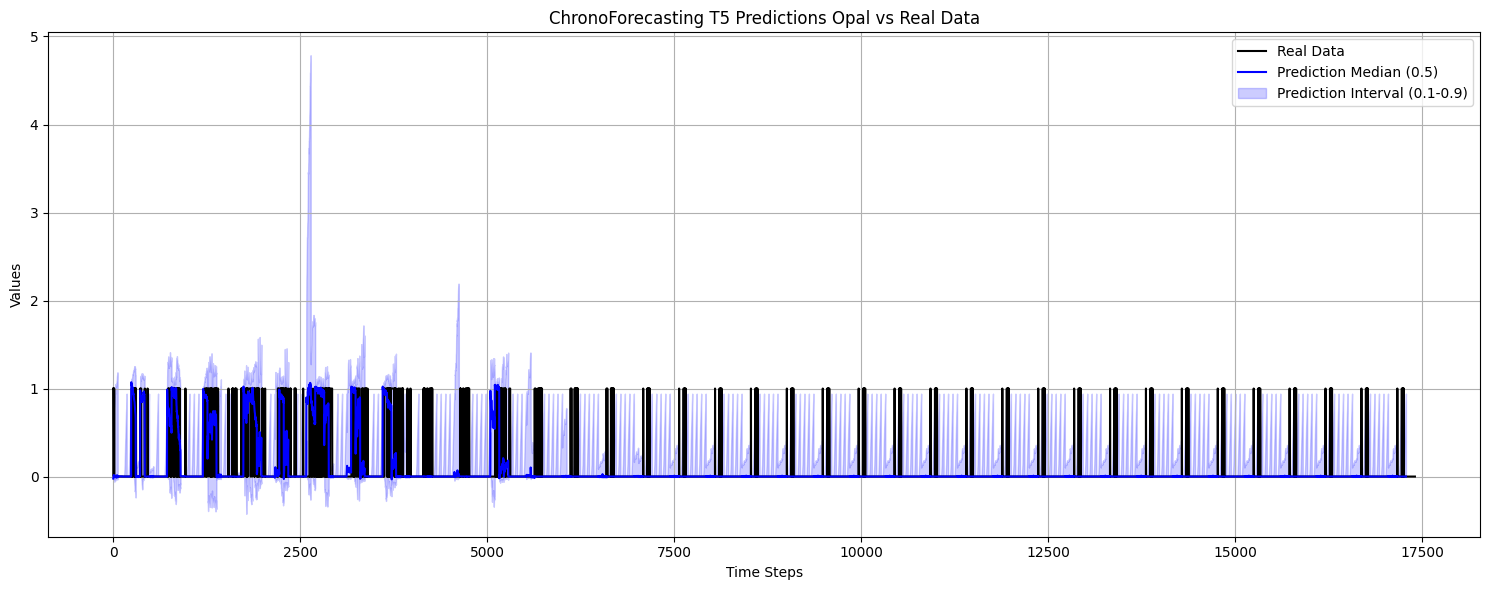

In [89]:
for name in ['Sadeh', 'Cole_kripke', 'Opal']:

    lows, medians, highs, real_data = results[name]
    plt.figure(figsize=(15, 6))
    plt.plot(real_data, label='Real Data', color='black')
    plt.plot(medians, label='Prediction Median (0.5)', color='blue')
    plt.fill_between(np.arange(len(medians)), lows, highs, color='blue', alpha=0.2, label='Prediction Interval (0.1-0.9)')
    plt.title(f'ChronoForecasting T5 Predictions {name} vs Real Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()